# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13278588.26it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 101226.42it/s]           
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4253142.76it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 34241.47it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Here I'll create a model like normal, using the same one from my solution for part 4.

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [10]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [11]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples

print(top_class[:10,:])

tensor([[8],
        [7],
        [1],
        [7],
        [7],
        [8],
        [8],
        [8],
        [7],
        [8]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [0]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [13]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 12.5%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    train_loss = 0 
    test_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    else:
        with torch.no_grad():

            ## TODO: Implement the validation pass and print out the validation accuracy
            accuracy = 0
            #step2 = 0
            for imagesT, labelsT in testloader:

                log_psT = model(imagesT)
                loss = criterion(log_psT, labelsT)
              
                psT = torch.exp(log_psT)
                prob, classIndex = psT.topk(1,dim=1)
                equals = classIndex == labelsT.view(*classIndex.shape)
                acc = torch.mean(equals.type(torch.FloatTensor))
                
                test_loss += loss.item()
                accuracy += acc.item()
                #track_acc[step2] = acc.item()
                #step2 += 1       
        
            else:
                #track_acc[steps]=accuracy/len(testloader)
                train_losses.append(train_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))
              
                #track_acc[steps] = accuracy/len(testloader)
                print(f'Accuracy: {accuracy*100/len(testloader)}%')      
                print(f'Train Losses: {train_loss/len(trainloader)}')
                print(f'Test Losses: {test_loss/len(testloader)}')
        


                
                 

Accuracy: 84.32523885350318%
Train Losses: 0.5236167143911187
Test Losses: 0.4443263666834801
Accuracy: 85.34036624203821%
Train Losses: 0.3910897000194358
Test Losses: 0.4100392972397956
Accuracy: 86.16640127388536%
Train Losses: 0.3568886053253974
Test Losses: 0.3904745209558754
Accuracy: 85.828025477707%
Train Losses: 0.33313070365519665
Test Losses: 0.3933341651205804
Accuracy: 86.98248407643312%
Train Losses: 0.31614514869222765
Test Losses: 0.36763170902516434
Accuracy: 87.06210191082802%
Train Losses: 0.3028374912419807
Test Losses: 0.3677478528041748
Accuracy: 86.64410828025478%
Train Losses: 0.29439750037340723
Test Losses: 0.3807614309962388
Accuracy: 86.15644904458598%
Train Losses: 0.28617998593047994
Test Losses: 0.3886267803846651
Accuracy: 86.63415605095541%
Train Losses: 0.27488383819966683
Test Losses: 0.3927413028706411
Accuracy: 87.80851910828025%
Train Losses: 0.26808217101529846
Test Losses: 0.35415336233415423
Accuracy: 86.91281847133757%
Train Losses: 0.260485908

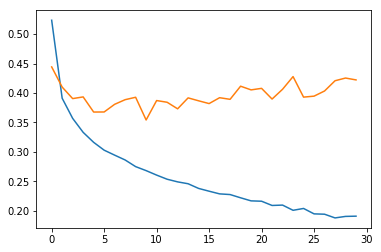

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(test_losses)
#track
#track_acc

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='https://github.com/leandromouralima/deep-learning/blob/master/intro-to-pytorch/assets/overfitting.png?raw=1' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [0]:
## TODO: Define your model with dropout added

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
        
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [19]:
## TODO: Train your model with dropout, and monitor the training progress with the validation loss and accuracy

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    train_loss = 0 
    test_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    else:
        with torch.no_grad():
            model.eval()
            ## TODO: Implement the validation pass and print out the validation accuracy
            accuracy = 0
            #step2 = 0
            for imagesT, labelsT in testloader:

                log_psT = model(imagesT)
                loss = criterion(log_psT, labelsT)
              
                psT = torch.exp(log_psT)
                prob, classIndex = psT.topk(1,dim=1)
                equals = classIndex == labelsT.view(*classIndex.shape)
                acc = torch.mean(equals.type(torch.FloatTensor))
                
                test_loss += loss.item()
                accuracy += acc.item()
                #track_acc[step2] = acc.item()
                #step2 += 1       
        
            else:
                model.train()
                #track_acc[steps]=accuracy/len(testloader)
                train_losses.append(train_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))
              
                #track_acc[steps] = accuracy/len(testloader)
                print(f'Accuracy: {accuracy*100/len(testloader)}%')      
                print(f'Train Losses: {train_loss/len(trainloader)}')
                print(f'Test Losses: {test_loss/len(testloader)}')
                

Accuracy: 80.8718152866242%
Train Losses: 0.6197168960658981
Test Losses: 0.5049219706635566
Accuracy: 84.28542993630573%
Train Losses: 0.476035726286455
Test Losses: 0.44710469094051675
Accuracy: 84.36504777070064%
Train Losses: 0.4587278801129698
Test Losses: 0.43384563467305176
Accuracy: 84.54418789808918%
Train Losses: 0.4370158102307747
Test Losses: 0.428741257756379
Accuracy: 84.98208598726114%
Train Losses: 0.42298920214303265
Test Losses: 0.41505729506729516
Accuracy: 85.53941082802548%
Train Losses: 0.4077826516428736
Test Losses: 0.4009753396366812
Accuracy: 86.00716560509554%
Train Losses: 0.40685568182770887
Test Losses: 0.3886530927032422
Accuracy: 86.6640127388535%
Train Losses: 0.4048114358934004
Test Losses: 0.38609782848388524
Accuracy: 85.64888535031847%
Train Losses: 0.39547686142199584
Test Losses: 0.4009177750273115
Accuracy: 85.62898089171975%
Train Losses: 0.38541206997086497
Test Losses: 0.3994376704951001
Accuracy: 86.35549363057325%
Train Losses: 0.38471387644

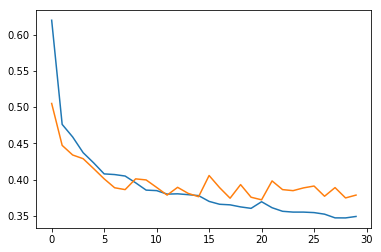

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(test_losses)
#track
#track_acc

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

In [23]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

AttributeError: ignored

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.